# Exploration of negative binomial models on real data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import janitor
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io import cache_io, data_io
from src.loggers import logger
from src.modeling import pymc3_sampling_api as pmapi
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_classic()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

For this analysis, I used the subsample of CRC data.

In [5]:
crc_subsample_file = data_io.DataFile.crc_subsample
crc_modeling_data_subsample = pd.read_csv(data_io.data_path(crc_subsample_file))
crc_modeling_data_subsample.head()

sgrna                  replicate_id       lfc  \
0   AACAACTAACTTTGTACAT                  LS513_c903R1  0.226828   
1   AACAAGATGTTTTGCCAAC                  LS513_c903R1  0.245798   
2   AACAGCTCGTTGTACCGCT                  LS513_c903R1 -2.819159   
3   AACGCATACCTTGAGCAAG                  LS513_c903R1 -1.188274   
4  AAGTTCCTCTGAAGTTCGCA  LS513-311Cas9_RepA_p6_batch2 -0.182191   

         p_dna_batch  genome_alignment hugo_symbol  screen  \
0  ERS717283.plasmid   chr8_81679130_-       IMPA1  sanger   
1  ERS717283.plasmid   chr17_7675205_-        TP53  sanger   
2  ERS717283.plasmid   chr3_41225481_+      CTNNB1  sanger   
3  ERS717283.plasmid   chr3_71046949_+       FOXP1  sanger   
4                  2  chr2_241704672_-        ING5   broad   

   multiple_hits_on_gene sgrna_target_chr  sgrna_target_pos  ...  \
0                   True                8          81679130  ...   
1                   True               17           7675205  ...   
2                   True                3          41225481  ...   
3                   True                3          71046949  ...   
4                   True                2         241704672  ...   

  num_mutations  any_deleterious  any_tcga_hotspot  any_cosmic_hotspot  \
0             0              NaN               NaN                 NaN   
1             0              NaN               NaN                 NaN   
2             0              NaN               NaN                 NaN   
3             0              NaN               NaN                 NaN   
4             0              NaN               NaN                 NaN   

  is_mutated copy_number     lineage  primary_or_metastasis  is_male   age  
0      False    0.957015  colorectal                primary     True  63.0  
1      False    0.970098  colorectal                primary     True  63.0  
2      False    0.964463  colorectal                primary     True  63.0  
3      False    0.949038  colorectal                primary     True  63.0  
4      False    0.973700  colorectal                primary     True  63.0  

[5 rows x 23 columns]

In [6]:
f"number of rows: {crc_modeling_data_subsample.shape[0]}"

'number of rows: 1443'

In [7]:
crc_modeling_data_subsample.hugo_symbol.unique()

array(['IMPA1', 'TP53', 'CTNNB1', 'FOXP1', 'ING5', 'NRAS', 'KRAS',
       'SEC23B', 'SOSTDC1', 'HSBP1L1', 'TMEM192', 'VCL', 'PLCD4',
       'SEC14L5', 'NOSTRIN', 'OTOF', 'APC', 'MDM2', 'CSDC2', 'MDM4',
       'INPP5A', 'FBXW7', 'KDELC1', 'TMPRSS3', 'FCN1', 'ADPRHL1',
       'CDK5RAP1', 'BRAF', 'LAPTM4B', 'RFWD3', 'KLF5', 'PTK2', 'DPY19L1',
       'RPL18A', 'SOWAHC', 'FAM92A', 'S100A7A', 'FUT7', 'PAFAH1B3',
       'DARS2', 'PLIN2', 'EEF1AKMT4', 'STK11', 'GATA6', 'SNX33',
       'EIF2AK1', 'TBX19', 'POU4F3', 'YY1', 'RPS26', 'CYTL1', 'ACVR1C',
       'SQLE', 'CCR3', 'NCDN', 'PLK5', 'POFUT2', 'SLC27A2', 'TXNDC17',
       'CCR9', 'GRIN2D', 'RTL3', 'PIK3CA', 'TMEM241'], dtype=object)

Unfortunately, most of the data points are missing read count data.
For now I will just drop these value.

In [8]:
# Percent of data missing read counts.
crc_modeling_data_subsample.read_counts.isna().mean()

0.604989604989605

In [9]:
data = (
    crc_modeling_data_subsample[~crc_modeling_data_subsample.read_counts.isna()]
    .copy()
    .reset_index(drop=True)
)

# Reset categorical data categories.
achelp.set_achilles_categorical_columns(data, sort_cats=True)

data.head()

sgrna                  replicate_id       lfc p_dna_batch  \
0  AAGTTCCTCTGAAGTTCGCA  LS513-311Cas9_RepA_p6_batch2 -0.182191           2   
1  AATGACTGAGTACAAACTGG  LS513-311Cas9_RepA_p6_batch2 -0.026600           2   
2  AATTACTACTTGCTTCCTGT  LS513-311Cas9_RepA_p6_batch2 -1.668700           2   
3  AGAAGTTTGGAGAGAGAACG  LS513-311Cas9_RepA_p6_batch2 -0.337427           2   
4  AGACACTTATACTATGAAAG  LS513-311Cas9_RepA_p6_batch2 -0.819049           2   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_241704672_-        ING5  broad                   True   
1  chr1_114716144_-        NRAS  broad                   True   
2  chr12_25227402_+        KRAS  broad                   True   
3  chr5_112838158_+         APC  broad                   True   
4  chr12_68813623_+        MDM2  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... num_mutations  any_deleterious  \
0                2         241704672  ...             0              NaN   
1                1         114716144  ...             0              NaN   
2               12          25227402  ...             1            False   
3                5         112838158  ...             0              NaN   
4               12          68813623  ...             0              NaN   

   any_tcga_hotspot  any_cosmic_hotspot is_mutated copy_number     lineage  \
0               NaN                 NaN      False    0.973700  colorectal   
1               NaN                 NaN      False    0.958285  colorectal   
2              True                True       True    0.963609  colorectal   
3               NaN                 NaN      False    1.262371  colorectal   
4               NaN                 NaN      False    0.963609  colorectal   

   primary_or_metastasis  is_male   age  
0                primary     True  63.0  
1                primary     True  63.0  
2                primary     True  63.0  
3                primary     True  63.0  
4                primary     True  63.0  

[5 rows x 23 columns]

The following table shows the number of sgRNA for each gene.

In [10]:
data[["hugo_symbol", "sgrna"]].drop_duplicates().groupby(
    "hugo_symbol"
).count().sort_values("sgrna")

sgrna
hugo_symbol       
ACVR1C           1
ING5             1
INPP5A           1
LAPTM4B          1
PAFAH1B3         1
PLCD4            1
PLIN2            1
PLK5             1
POU4F3           1
PTK2             1
RTL3             1
SEC14L5          1
SNX33            1
SOSTDC1          1
SOWAHC           1
TMPRSS3          1
TP53             1
TXNDC17          1
IMPA1            1
HSBP1L1          1
NCDN             1
GRIN2D           1
FCN1             1
APC              1
CYTL1            1
FBXW7            1
DPY19L1          1
EEF1AKMT4        1
CCR9             1
FAM92A           1
GATA6            2
SEC23B           2
CDK5RAP1         2
SQLE             2
CSDC2            2
STK11            2
TBX19            2
TMEM192          2
TMEM241          2
BRAF             2
ADPRHL1          2
CCR3             2
S100A7A          2
RFWD3            2
DARS2            2
EIF2AK1          2
PIK3CA           2
NRAS             2
NOSTRIN          2
VCL              2
KRAS             2
KLF5             2
KDELC1           2
FUT7             2
CTNNB1           2
RPS26            3
RPL18A           3
POFUT2           3
MDM2             3
YY1              3

The next few plots show the distributino of LFC and read count values.

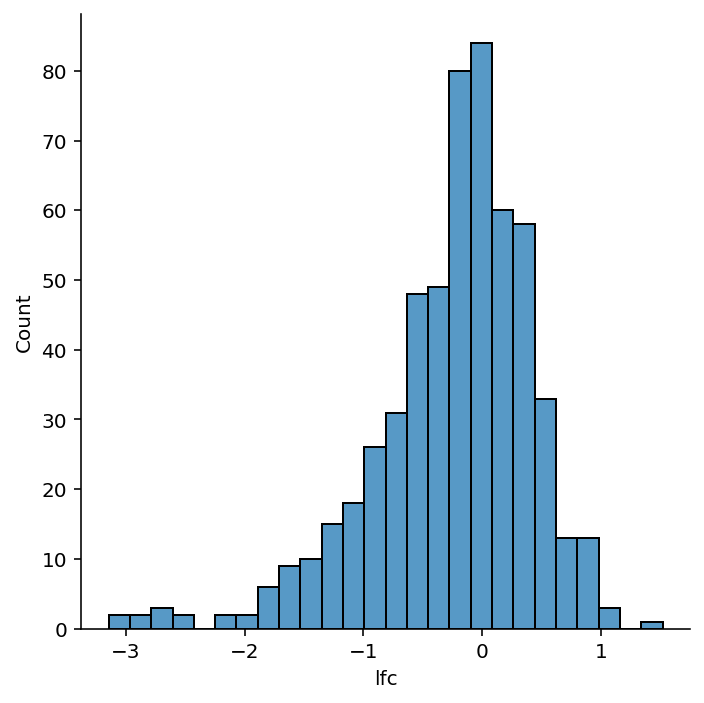

In [11]:
sns.displot(data=data, x="lfc");

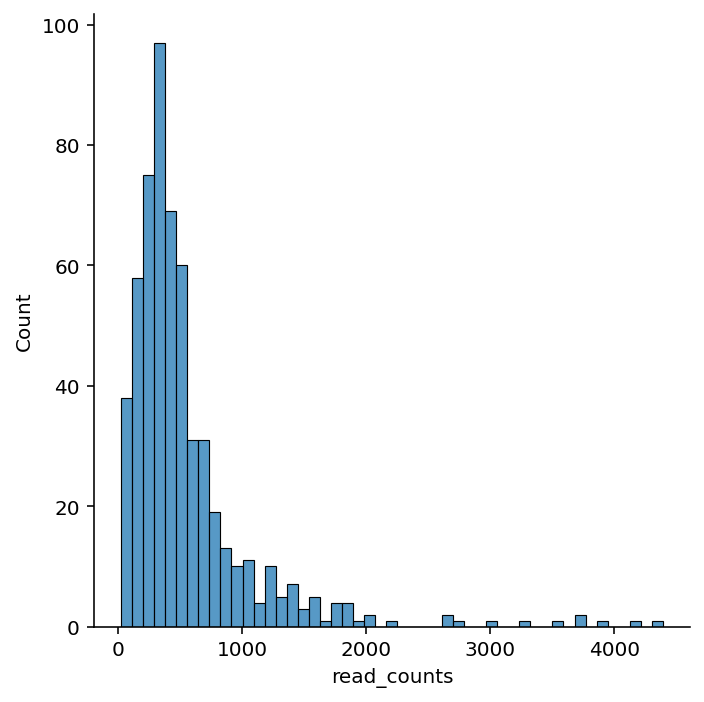

In [12]:
sns.displot(data=data, x="read_counts", kind="hist");

In [13]:
data.read_counts.agg(["mean", "var"])

mean       554.850877
var     313659.209709
Name: read_counts, dtype: float64

In [14]:
data["initial_reads"] = data.read_counts / (2 ** data.lfc)

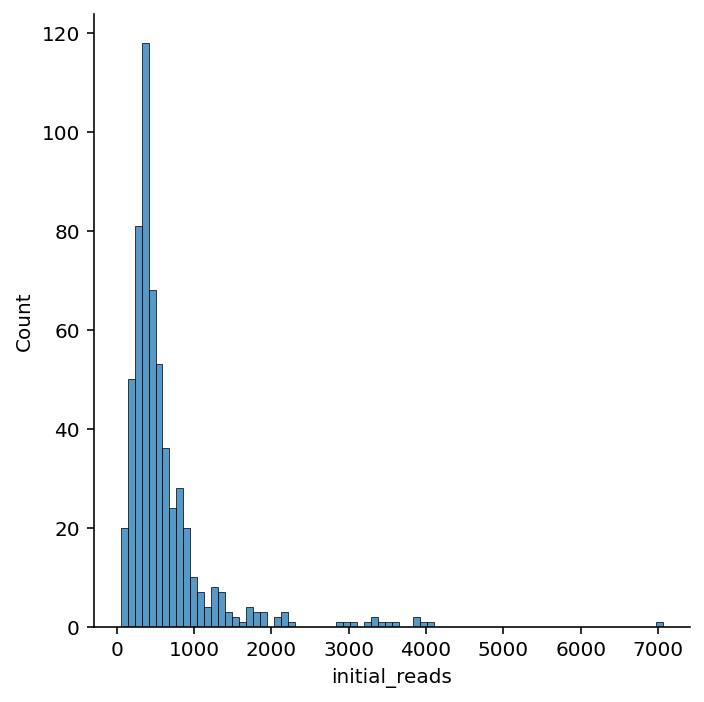

In [15]:
sns.displot(data, x="initial_reads", kind="hist");

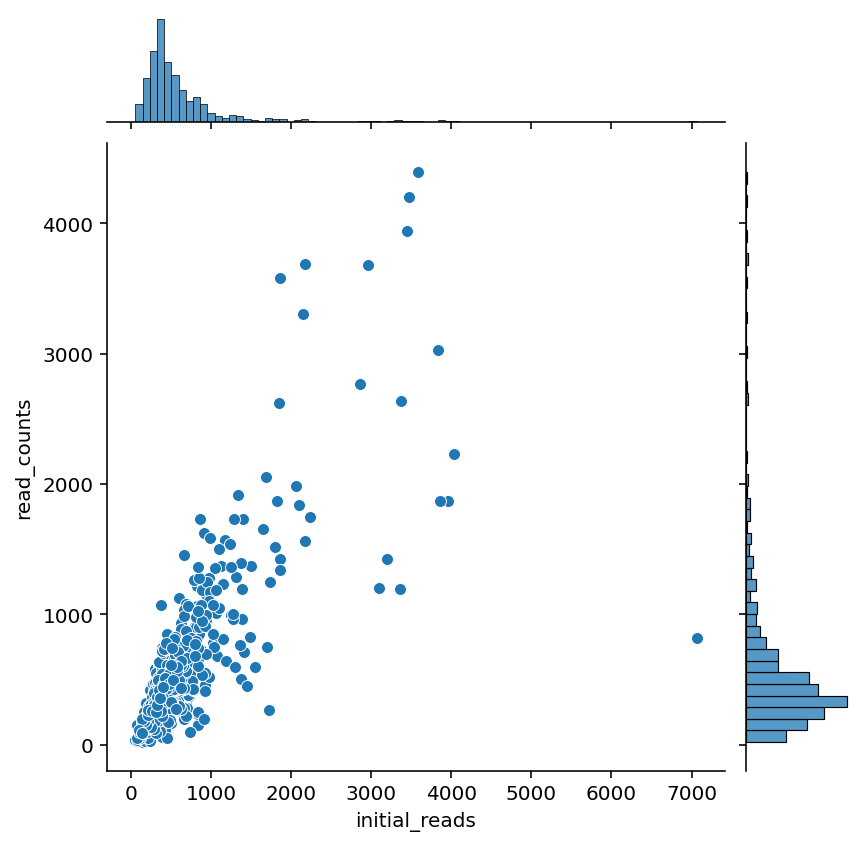

In [16]:
sns.jointplot(data=data, x="initial_reads", y="read_counts");

The following plot shows the distribution of reads with the *KRAS* data points highlighted for reference.

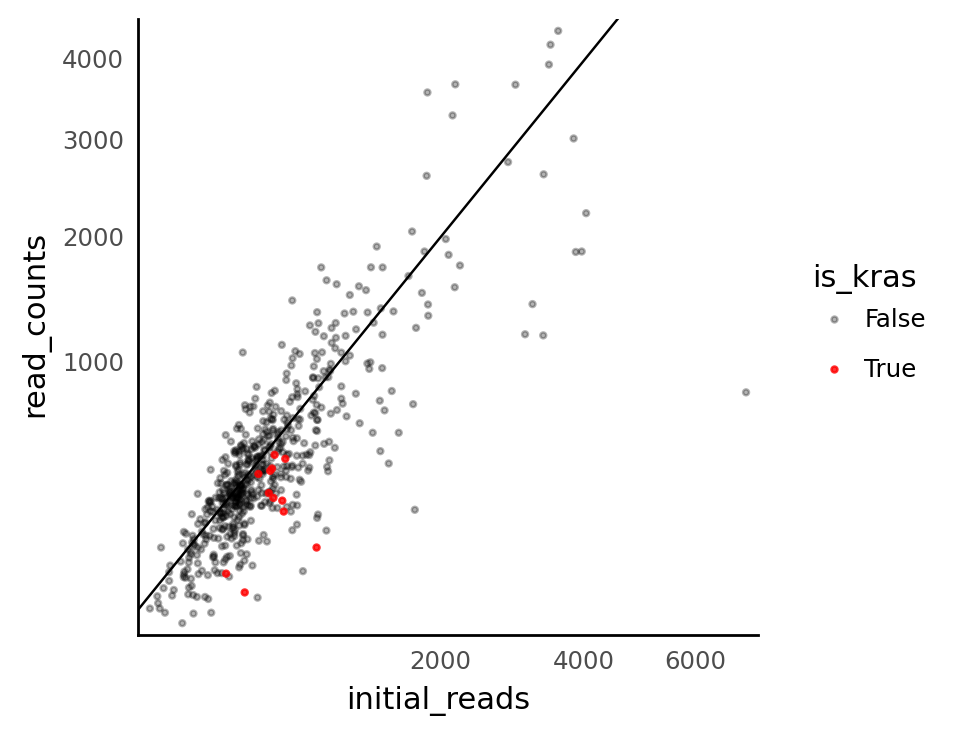

<ggplot: (351378929)>

In [17]:
plot_data = (
    data.copy().assign(is_kras=lambda d: d.hugo_symbol == "KRAS").sort_values("is_kras")
)

(
    gg.ggplot(plot_data, gg.aes(x="initial_reads", y="read_counts"))
    + gg.geom_point(gg.aes(color="is_kras", alpha="is_kras"), size=0.7)
    + gg.geom_abline(slope=1, intercept=0)
    + gg.scale_x_sqrt(expand=(0.02, 0, 0.02, 0))
    + gg.scale_y_sqrt(expand=(0.02, 0, 0.02, 0))
    + gg.scale_color_manual(values={True: "red", False: "k"})
    + gg.scale_alpha_manual(values={True: 0.8, False: 0.3})
)

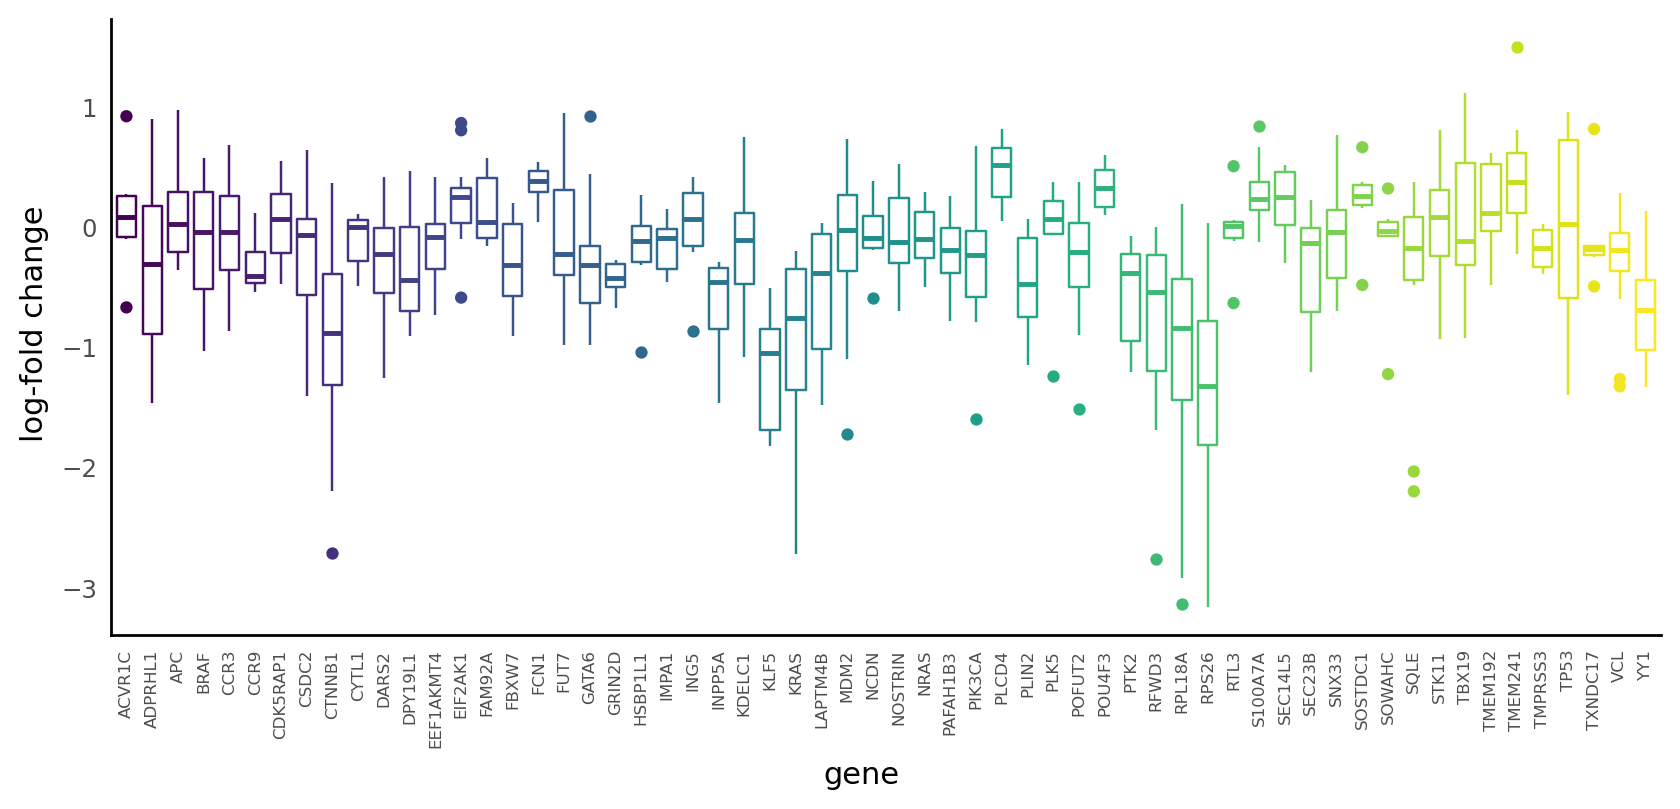

<ggplot: (351275370)>

In [18]:
(
    gg.ggplot(data, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_boxplot(gg.aes(color="hugo_symbol"))
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=6),
        legend_position="none",
        figure_size=(10, 4),
    )
    + gg.labs(x="gene", y="log-fold change")
)

## Model 0. Single gene

In [70]:
# TODO

## Model 1. Varying per gene

The first model is simple with a varying intercept per gene.
The starting read count is treated as an exposure value and multiplied directly against $\mu$.

$$
\begin{gather}
\mu_\beta \sim N(0, 5) \\
\sigma_\beta \sim HN(5) \\
\beta_g \sim_g N(\mu_\beta, \sigma_\beta) \\
\eta = \beta_g[\text{gene}] \\
\mu = \exp(\eta) \\
\alpha = HN(5) \\
y \sim \text{NB}(\mu X_\text{initial}, \alpha)
\end{gather}
$$

In [19]:
n_genes = len(data.hugo_symbol.unique())
gene_idx = dphelp.get_indices(data, "hugo_symbol")

with pm.Model() as nb_m1:
    g = pm.Data("gene_idx", gene_idx)
    initial_reads = pm.Data("initial_reads", data.initial_reads)
    final_reads = pm.Data("final_reads", data.read_counts)

    μ_β = pm.Normal("μ_β", 0, 2.5)
    σ_β = pm.HalfNormal("σ_β", 2.5)
    β_g = pm.Normal("β_g", μ_β, σ_β, shape=n_genes)
    η = pm.Deterministic("η", β_g[g])
    μ = pm.Deterministic("μ", pm.math.exp(η))
    α = pm.HalfNormal("α", 5)
    y = pm.NegativeBinomial("y", μ * initial_reads, α, observed=final_reads)

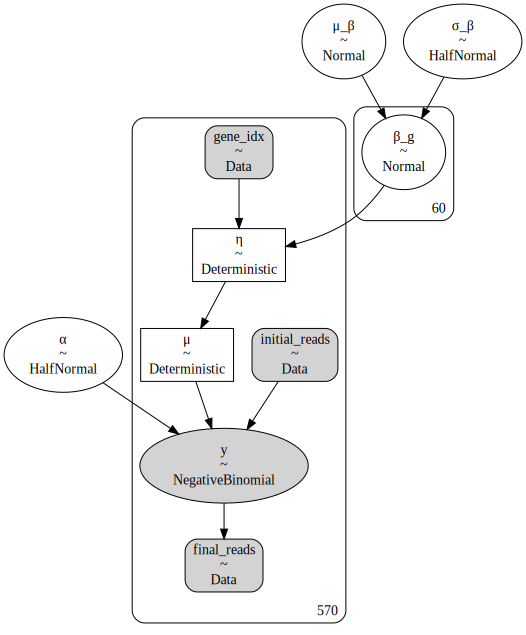

In [20]:
pm.model_to_graphviz(nb_m1)

In [21]:
with nb_m1:
    m1_trace = pm.sample(1000, tune=2000, random_seed=True, return_inferencedata=True)
    m1_trace.extend(
        az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(m1_trace))
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β_g, σ_β, μ_β]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 28 seconds.


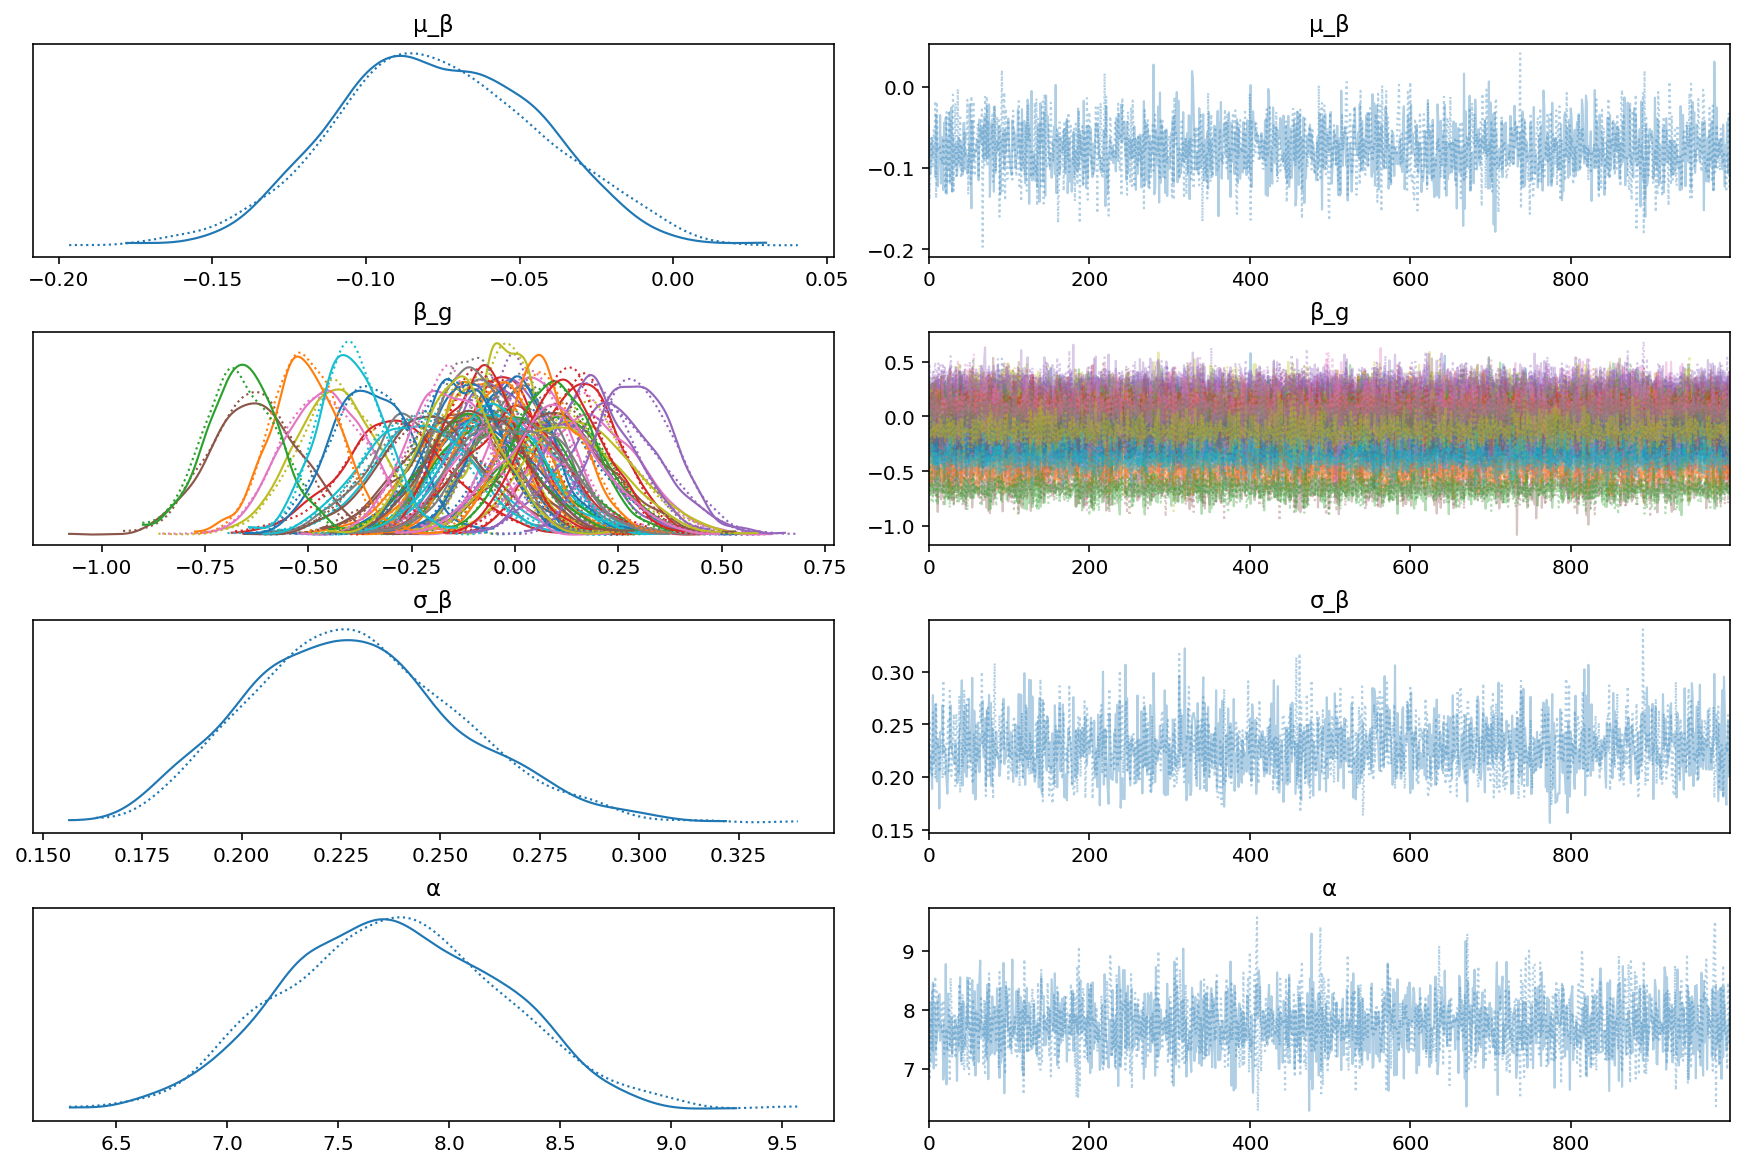

In [22]:
az.plot_trace(m1_trace, var_names=["α", "β"], filter_vars="like");

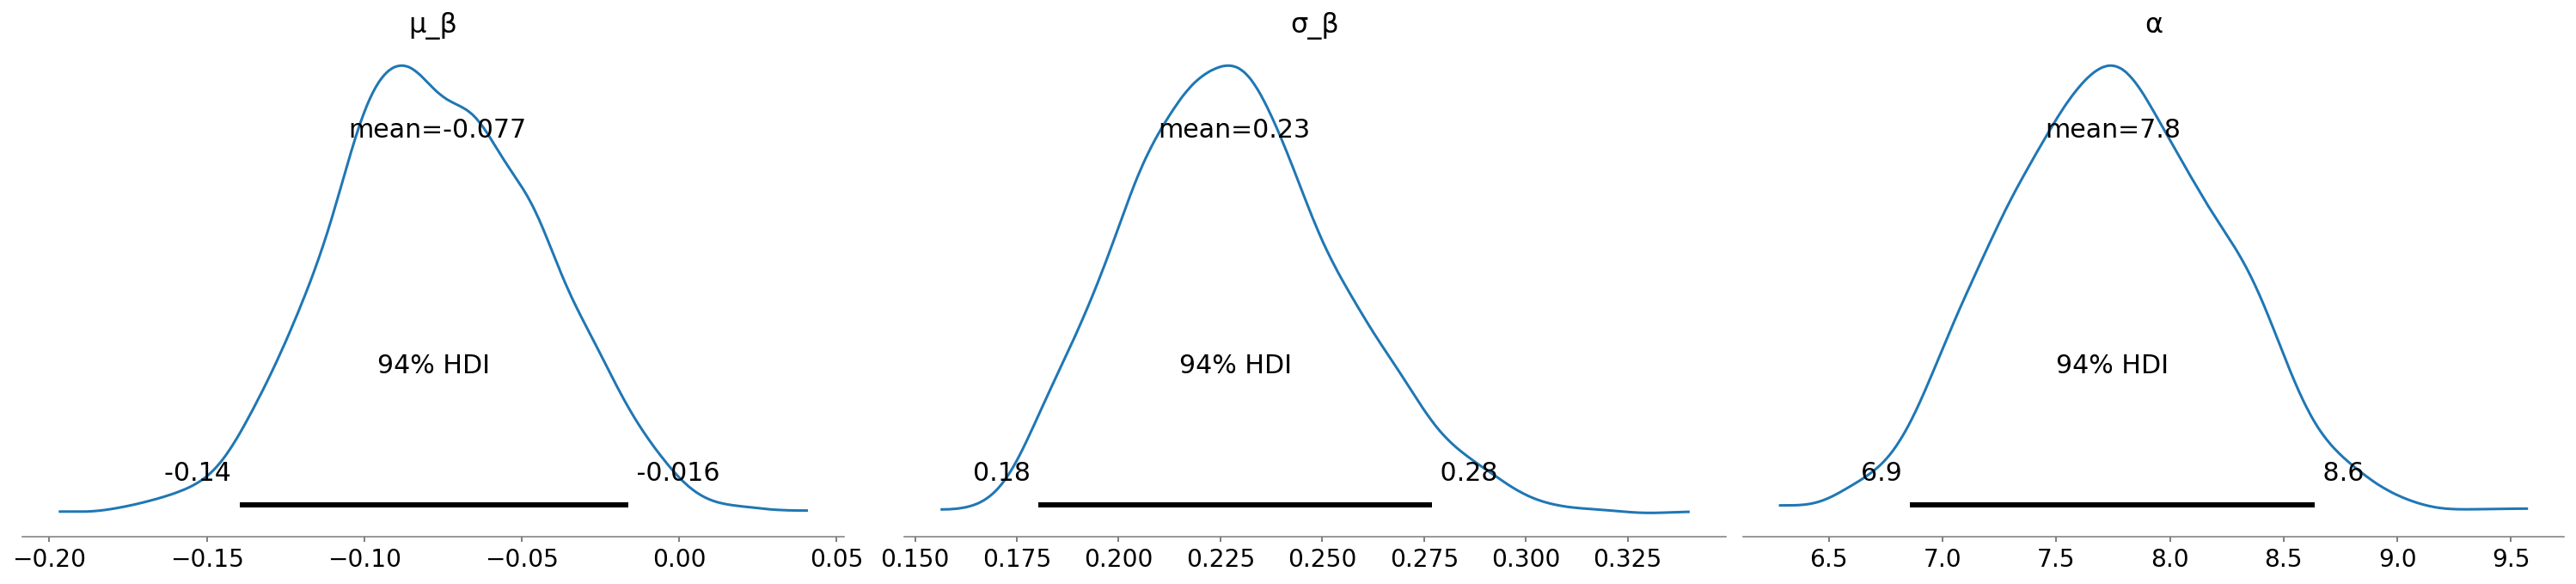

In [23]:
az.plot_posterior(m1_trace, var_names=["μ_β", "σ_β", "α"]);

The interpretation of the values for $\beta_g$ are as follows: For gene $j$, the expected change to the number of log final read counts is $\beta_j$.
Therefore, if $\beta_j = 0$, there is expected to be a change in the count of final reads $\exp(0) = 1$.
If $\beta_j$ is positive, then there is expected to be 

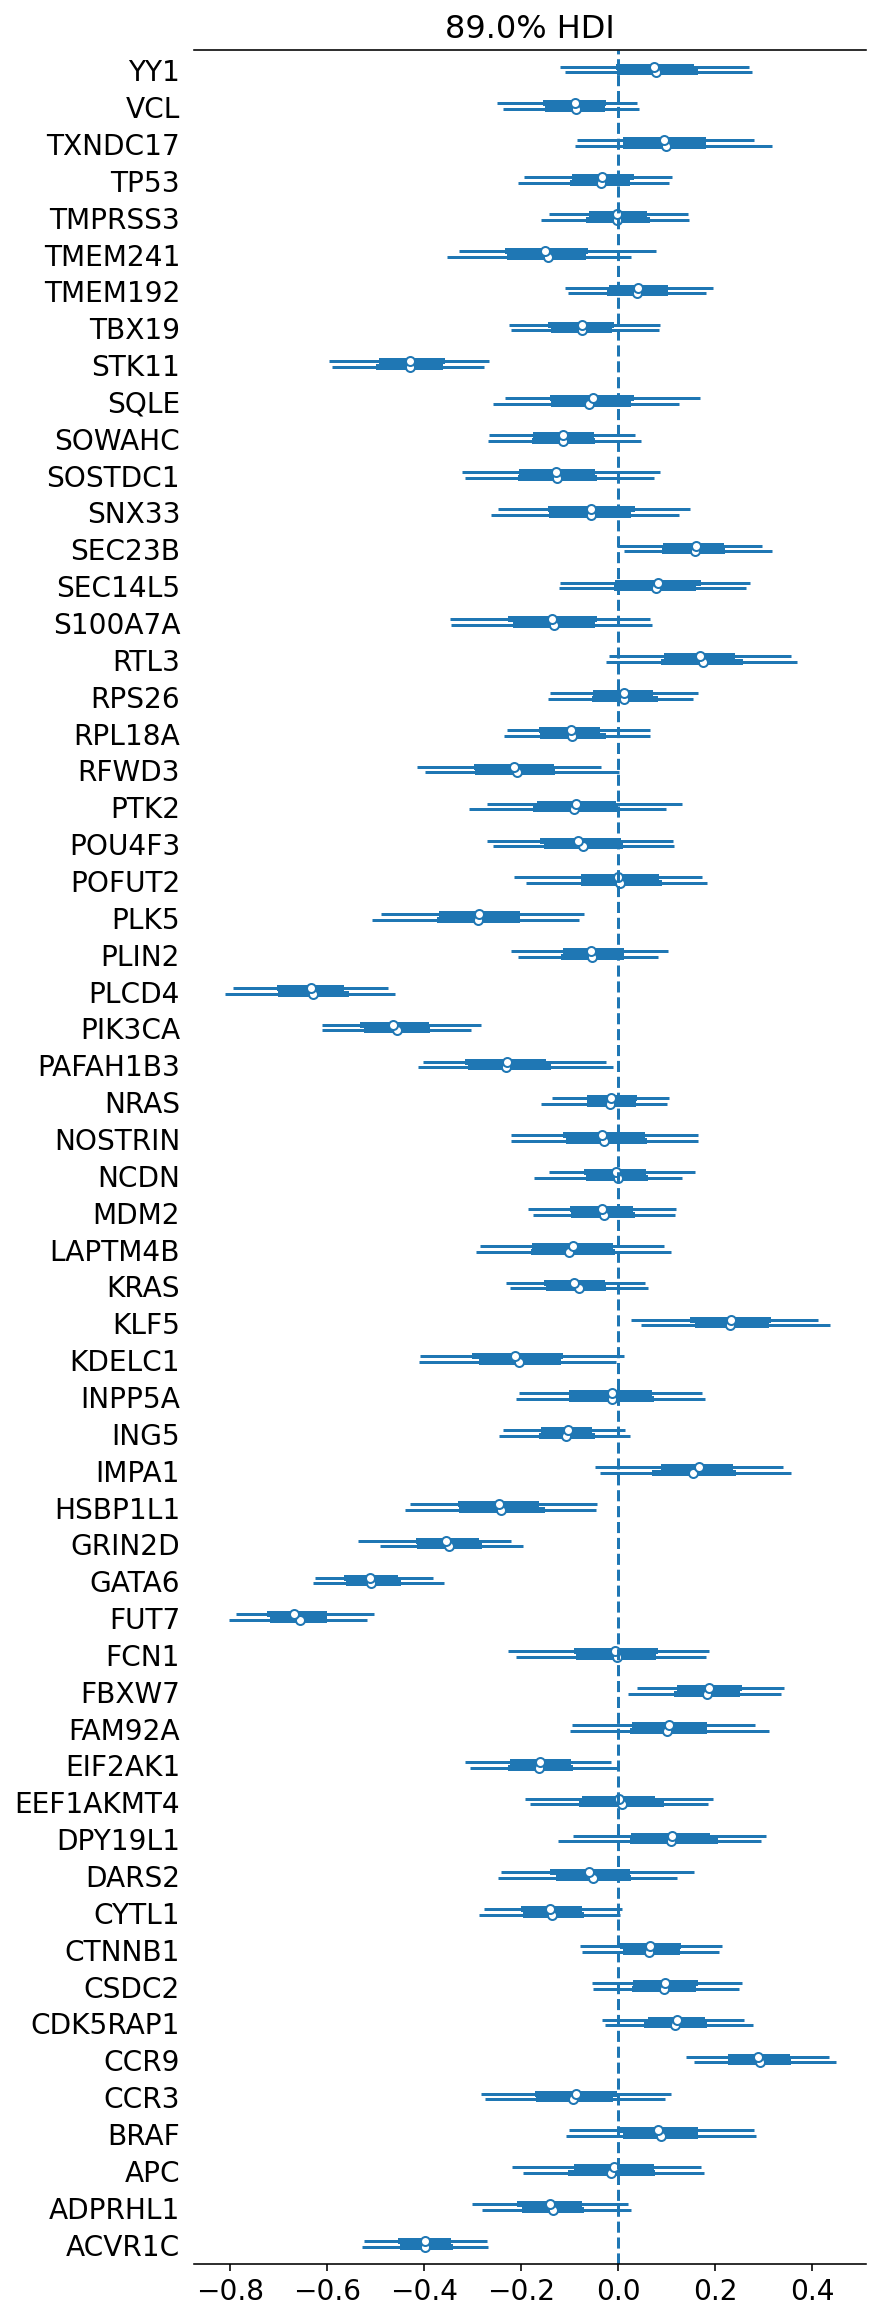

In [24]:
ax = az.plot_forest(m1_trace, var_names="β_g", hdi_prob=0.89)
ax[0].set_yticklabels(data.hugo_symbol.cat.categories)
plt.axvline(x=0, ls="--")
plt.show()

In [25]:
az.summary(m1_trace, var_names="β_g", hdi_prob=0.89).assign(
    hugo_symbol=data.hugo_symbol.cat.categories
)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
β_g[0]   0.081  0.122    -0.119      0.270      0.002    0.002    4871.0   
β_g[1]  -0.089  0.091    -0.241      0.044      0.002    0.002    3490.0   
β_g[2]   0.095  0.125    -0.090      0.292      0.002    0.002    4986.0   
β_g[3]  -0.035  0.096    -0.174      0.136      0.001    0.002    5220.0   
β_g[4]  -0.000  0.093    -0.160      0.138      0.001    0.002    4741.0   
β_g[5]  -0.148  0.124    -0.327      0.072      0.002    0.002    4831.0   
β_g[6]   0.042  0.096    -0.113      0.182      0.001    0.002    4584.0   
β_g[7]  -0.075  0.098    -0.220      0.090      0.001    0.002    5183.0   
β_g[8]  -0.428  0.102    -0.588     -0.267      0.002    0.001    3889.0   
β_g[9]  -0.055  0.124    -0.257      0.137      0.002    0.003    4802.0   
β_g[10] -0.113  0.097    -0.278      0.031      0.002    0.002    3487.0   
β_g[11] -0.125  0.126    -0.321      0.078      0.002    0.002    4085.0   
β_g[12] -0.055  0.125    -0.249      0.144      0.002    0.003    4937.0   
β_g[13]  0.157  0.096     0.008      0.310      0.002    0.001    3816.0   
β_g[14]  0.081  0.125    -0.122      0.268      0.002    0.003    5718.0   
β_g[15] -0.134  0.131    -0.347      0.066      0.002    0.002    5382.0   
β_g[16]  0.172  0.122    -0.025      0.357      0.002    0.002    4117.0   
β_g[17]  0.012  0.097    -0.132      0.172      0.002    0.002    4011.0   
β_g[18] -0.095  0.094    -0.233      0.065      0.002    0.001    3520.0   
β_g[19] -0.212  0.125    -0.413     -0.023      0.002    0.002    5428.0   
β_g[20] -0.088  0.129    -0.296      0.111      0.002    0.003    4386.0   
β_g[21] -0.075  0.120    -0.267      0.112      0.002    0.002    4715.0   
β_g[22]  0.006  0.121    -0.198      0.186      0.002    0.003    4770.0   
β_g[23] -0.286  0.132    -0.497     -0.071      0.002    0.002    4213.0   
β_g[24] -0.052  0.097    -0.218      0.091      0.002    0.002    3979.0   
β_g[25] -0.631  0.107    -0.792     -0.454      0.002    0.001    4153.0   
β_g[26] -0.459  0.102    -0.622     -0.303      0.002    0.001    3797.0   
β_g[27] -0.228  0.124    -0.429     -0.037      0.002    0.002    3199.0   
β_g[28] -0.013  0.078    -0.145      0.107      0.001    0.002    4700.0   
β_g[29] -0.028  0.122    -0.220      0.165      0.002    0.003    4937.0   
β_g[30] -0.003  0.097    -0.149      0.156      0.001    0.002    5125.0   
β_g[31] -0.032  0.096    -0.176      0.123      0.001    0.002    4768.0   
β_g[32] -0.092  0.124    -0.269      0.125      0.002    0.002    5261.0   
β_g[33] -0.087  0.091    -0.225      0.063      0.001    0.002    4260.0   
β_g[34]  0.234  0.120     0.028      0.417      0.002    0.002    3983.0   
β_g[35] -0.205  0.131    -0.411      0.005      0.002    0.002    5447.0   
β_g[36] -0.013  0.125    -0.211      0.178      0.002    0.003    5285.0   
β_g[37] -0.105  0.082    -0.248      0.014      0.001    0.001    4775.0   
β_g[38]  0.162  0.122    -0.038      0.353      0.002    0.002    4245.0   
β_g[39] -0.244  0.125    -0.434     -0.041      0.002    0.002    3742.0   
β_g[40] -0.349  0.096    -0.498     -0.192      0.001    0.001    4340.0   
β_g[41] -0.508  0.082    -0.631     -0.371      0.001    0.001    4304.0   
β_g[42] -0.660  0.089    -0.800     -0.514      0.001    0.001    4492.0   
β_g[43] -0.003  0.127    -0.227      0.176      0.002    0.003    4415.0   
β_g[44]  0.186  0.098     0.030      0.342      0.001    0.001    4676.0   
β_g[45]  0.106  0.124    -0.096      0.300      0.002    0.002    4090.0   
β_g[46] -0.161  0.096    -0.308     -0.005      0.001    0.001    4773.0   
β_g[47]  0.005  0.121    -0.183      0.195      0.002    0.003    4406.0   
β_g[48]  0.112  0.128    -0.093      0.319      0.002    0.003    4438.0   
β_g[49] -0.052  0.121    -0.242      0.142      0.002    0.003    4520.0   
β_g[50] -0.134  0.091    -0.285      0.006      0.002    0.001    3662.0   
β_g[51]  0.067  0.091    -0.080      0.207      0.001    0

The following plot shows the raw data for a few genes with large posterior estimates for $\beta$ in model 1.

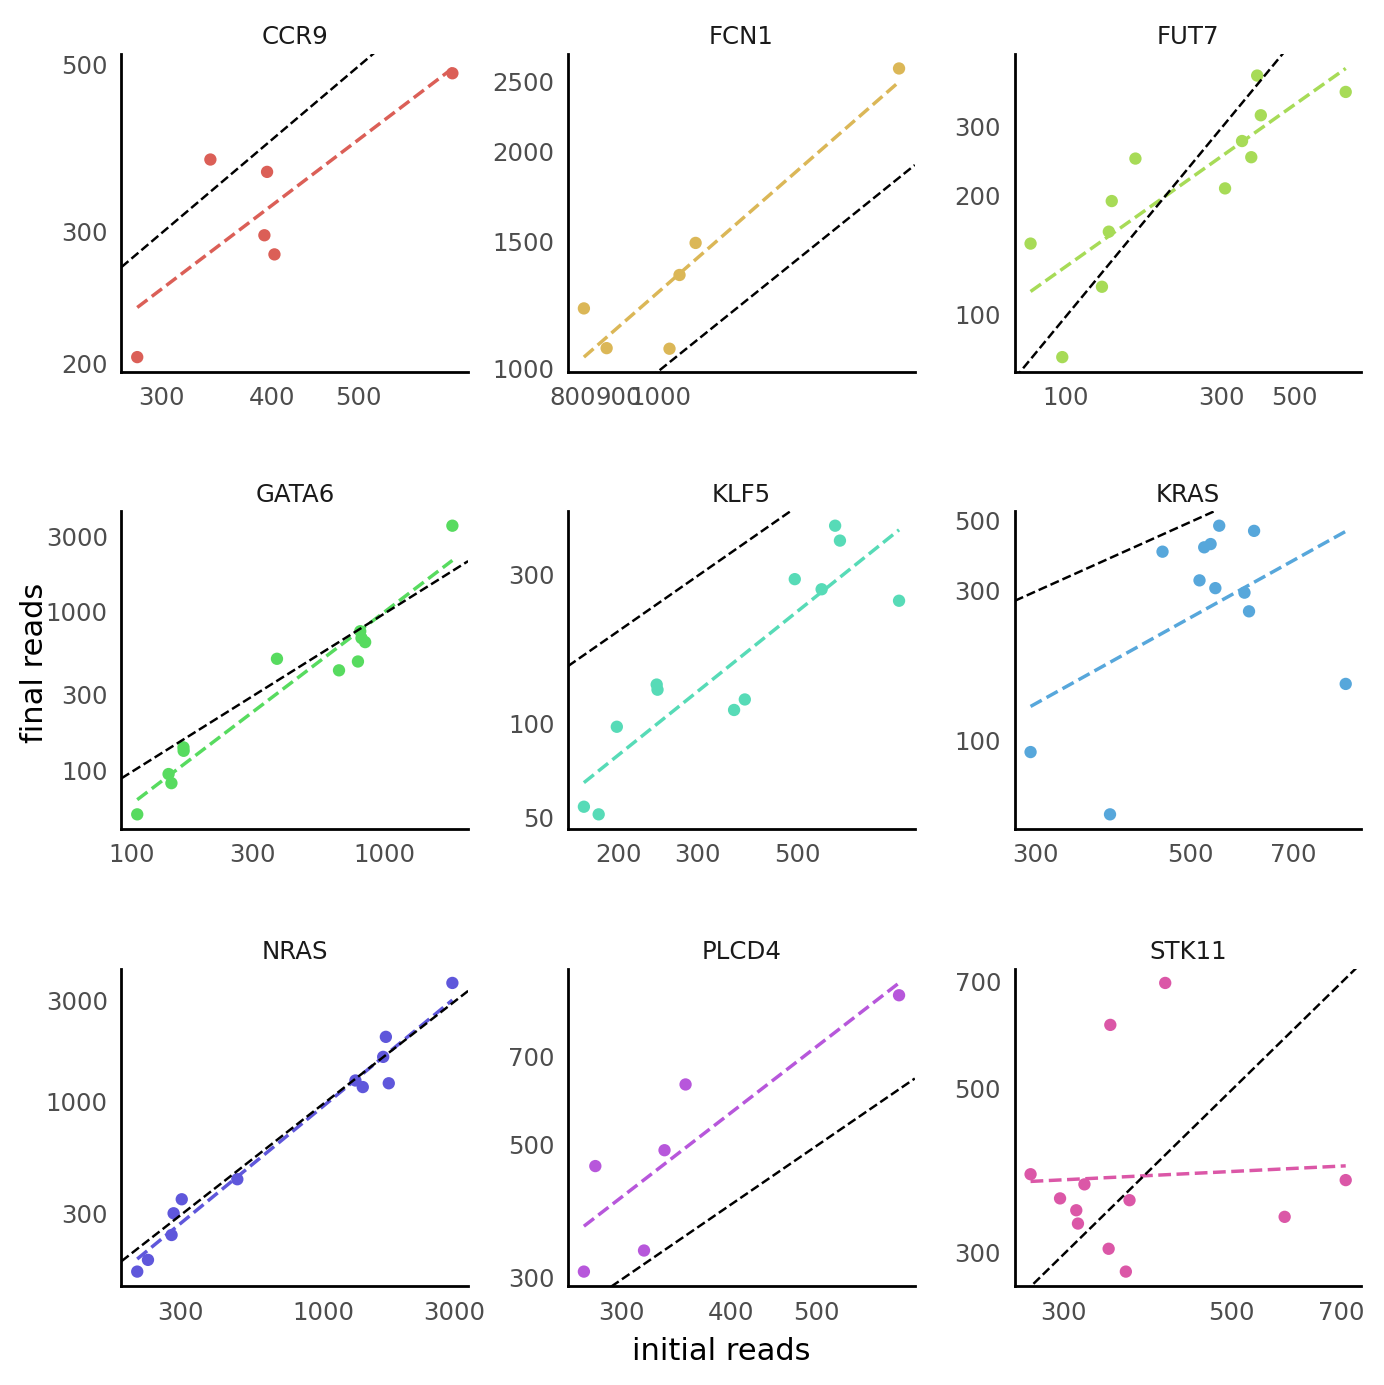

<ggplot: (362459901)>

In [66]:
g = ["FUT7", "STK11", "GATA6", "KRAS", "KLF5", "CCR9", "FCN1", "NRAS", "PLCD4"]

(
    gg.ggplot(
        data[data.hugo_symbol.isin(g)].astype({"hugo_symbol": str}),
        gg.aes(x="initial_reads", y="read_counts", color="hugo_symbol"),
    )
    + gg.facet_wrap("~ hugo_symbol", ncol=3, scales="free")
    + gg.geom_point()
    + gg.geom_smooth(method="lm", formula="y~x", se=False, size=0.7, linetype="--")
    + gg.geom_abline(slope=1, intercept=0, linetype="--", color="k")
    + gg.scale_x_log10()
    + gg.scale_y_log10()
    + gg.theme(figure_size=(8, 8), panel_spacing=0.5, legend_position="none")
    + gg.labs(x="initial reads", y="final reads")
)

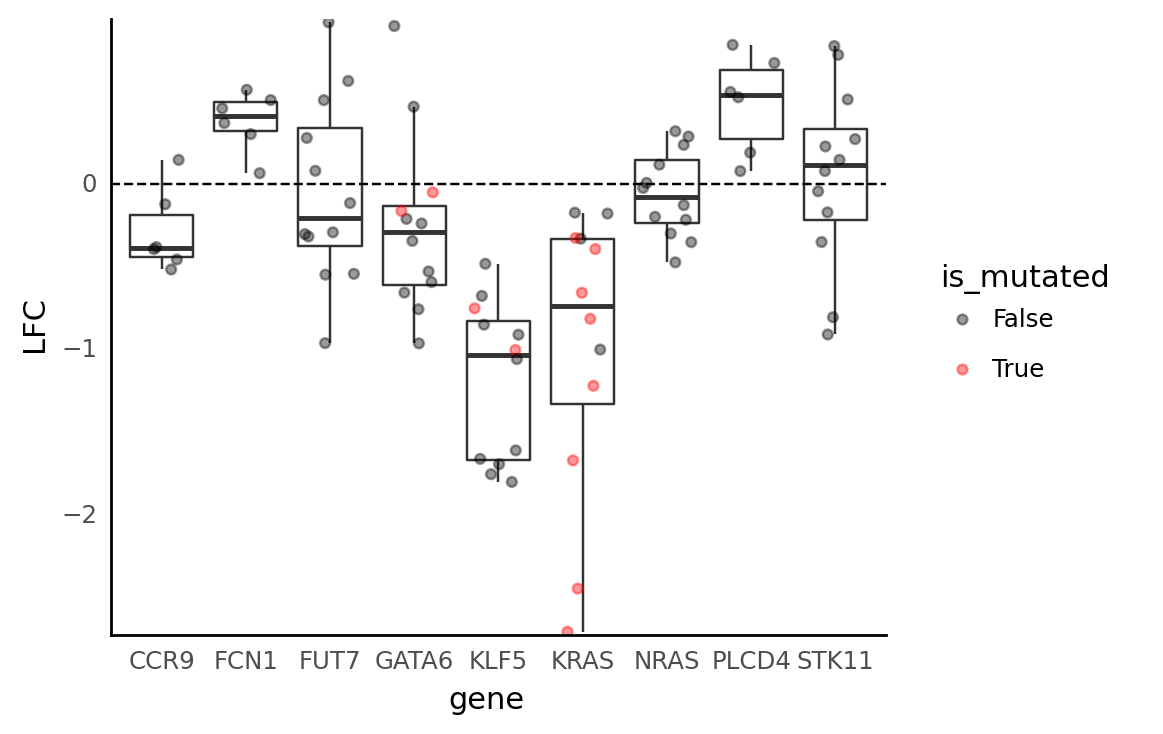

<ggplot: (357150847)>

In [58]:
(
    gg.ggplot(
        data[data.hugo_symbol.isin(g)].astype({"hugo_symbol": str}),
        gg.aes(x="hugo_symbol", y="lfc"),
    )
    + gg.geom_boxplot(outlier_alpha=0)
    + gg.geom_jitter(gg.aes(color="is_mutated"), width=0.3, height=0, alpha=0.4)
    + gg.geom_hline(yintercept=0, linetype="--")
    + gg.scale_y_continuous(expand=(0, 0.02, 0, 0.02))
    + gg.scale_color_manual(values={True: "red", False: "black"})
    + gg.theme(figure_size=(5, 4))
    + gg.labs(x="gene", y="LFC")
)

Below are some explorations of the posterior predictions of the model.
Generally, they make sense and seem reasonable.

In [28]:
def down_sample_ppc(ppc_ary: np.ndarray, n: int) -> tuple[np.ndarray, np.ndarray]:
    r_idx = np.arange(ppc_ary.shape[1])
    np.random.shuffle(r_idx)
    return ppc_ary[:, r_idx[:n]], r_idx

In [29]:
m1_ppc_sample, sample_idx = down_sample_ppc(
    m1_trace["posterior_predictive"]["y"].squeeze().values, n=10
)

In [30]:
m1_ppc_df = (
    pd.concat(
        [
            pd.DataFrame(m1_ppc_sample.T),
            data.loc[sample_idx[:10], :][["hugo_symbol", "sgrna"]].reset_index(
                drop=True
            ),
        ],
        axis=1,
    )
    .assign(ppc_idx=lambda d: np.arange(d.shape[0]))
    .pivot_longer(
        index=["hugo_symbol", "sgrna", "ppc_idx"], names_to="_to_drop", values_to="draw"
    )
    .drop(columns="_to_drop")
)

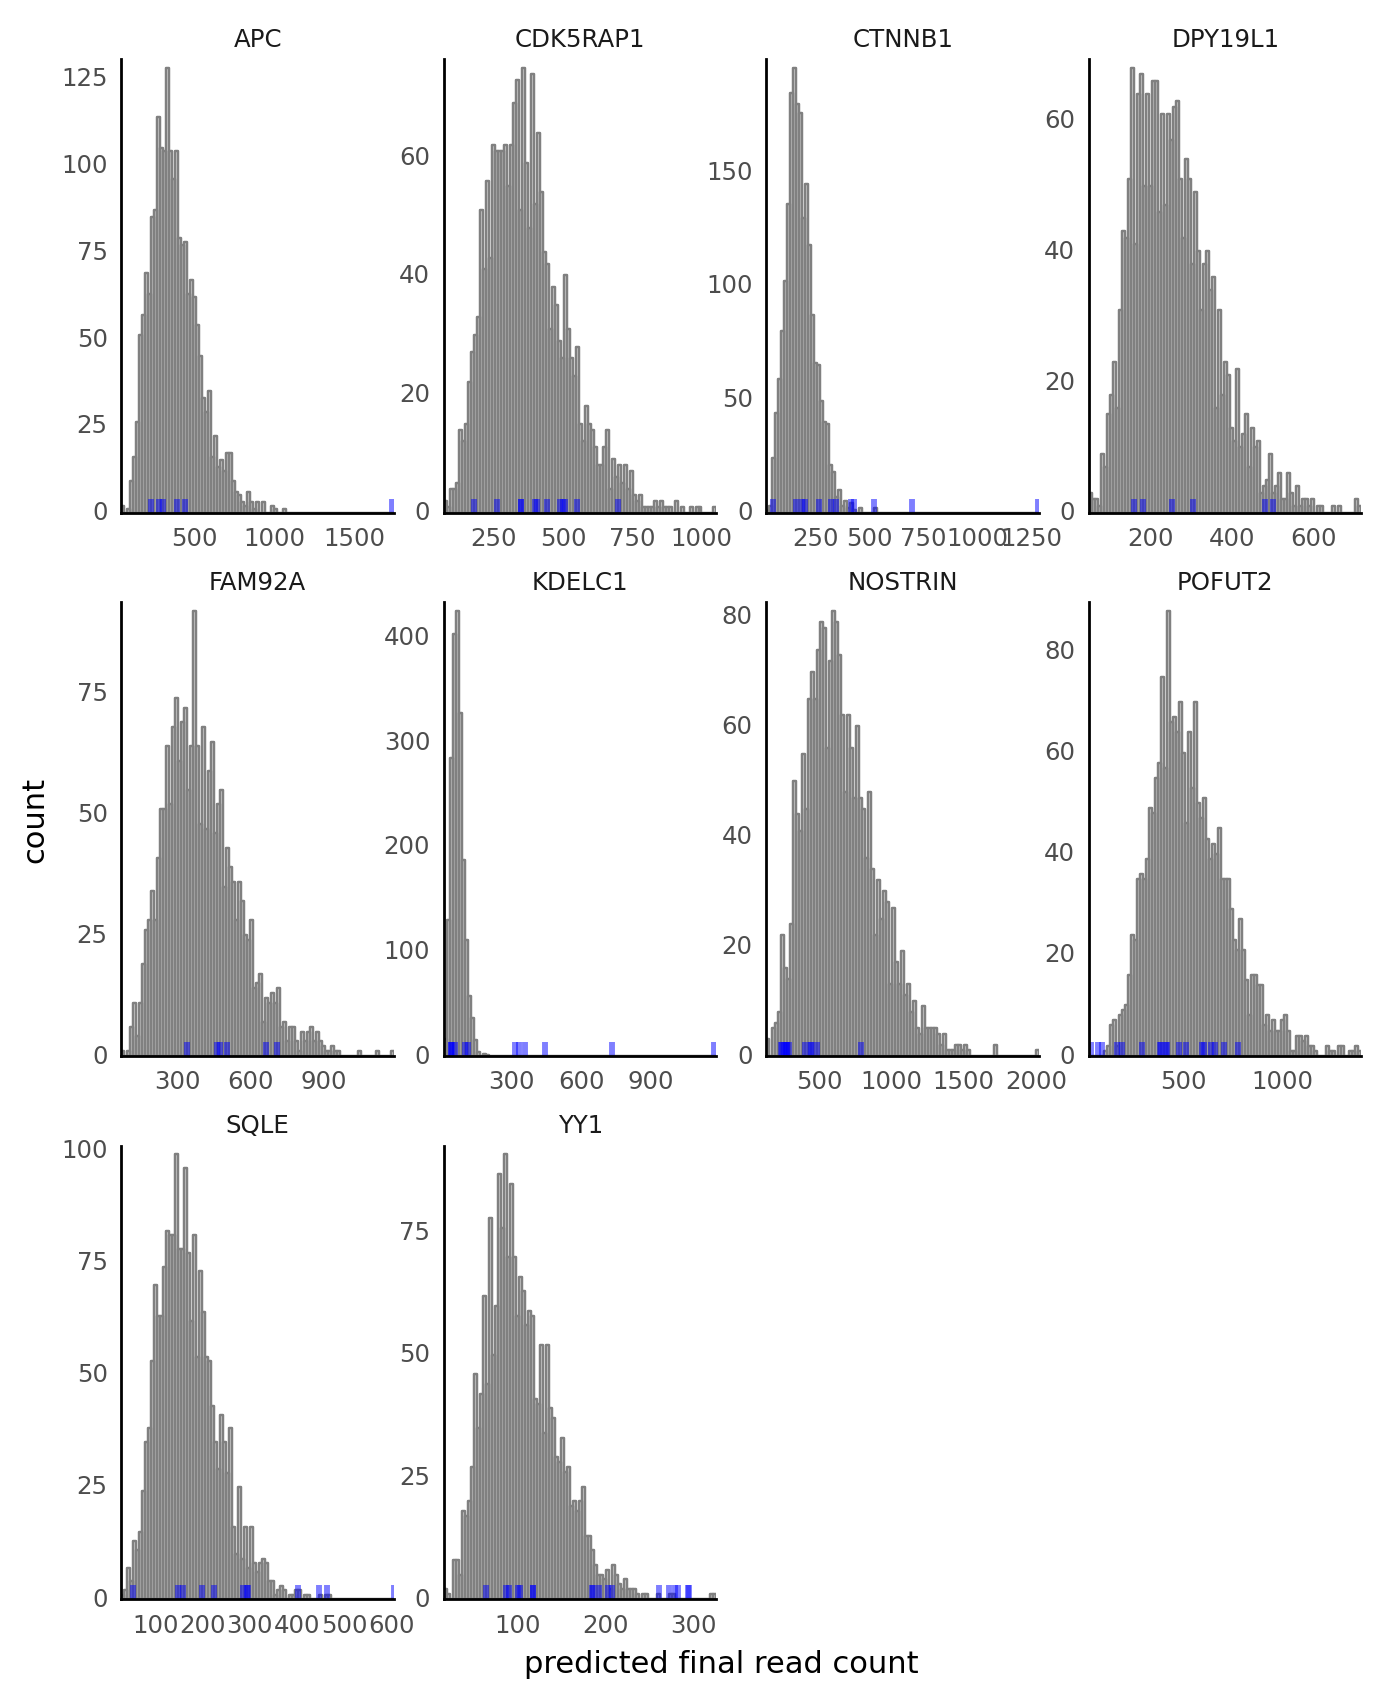

<ggplot: (356057793)>

In [31]:
(
    gg.ggplot(m1_ppc_df)
    + gg.facet_wrap("~hugo_symbol", ncol=4, scales="free")
    + gg.geom_histogram(gg.aes(x="draw"), color="grey", fill="grey", alpha=0.2)
    + gg.geom_rug(
        gg.aes(x="read_counts"),
        data=data[data.hugo_symbol.isin(m1_ppc_df.hugo_symbol)],
        color="b",
        size=1.2,
        alpha=0.5,
    )
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(figure_size=(8, 10), panel_spacing_x=0.25, panel_spacing_y=0.25)
    + gg.labs(x="predicted final read count", y="count")
)

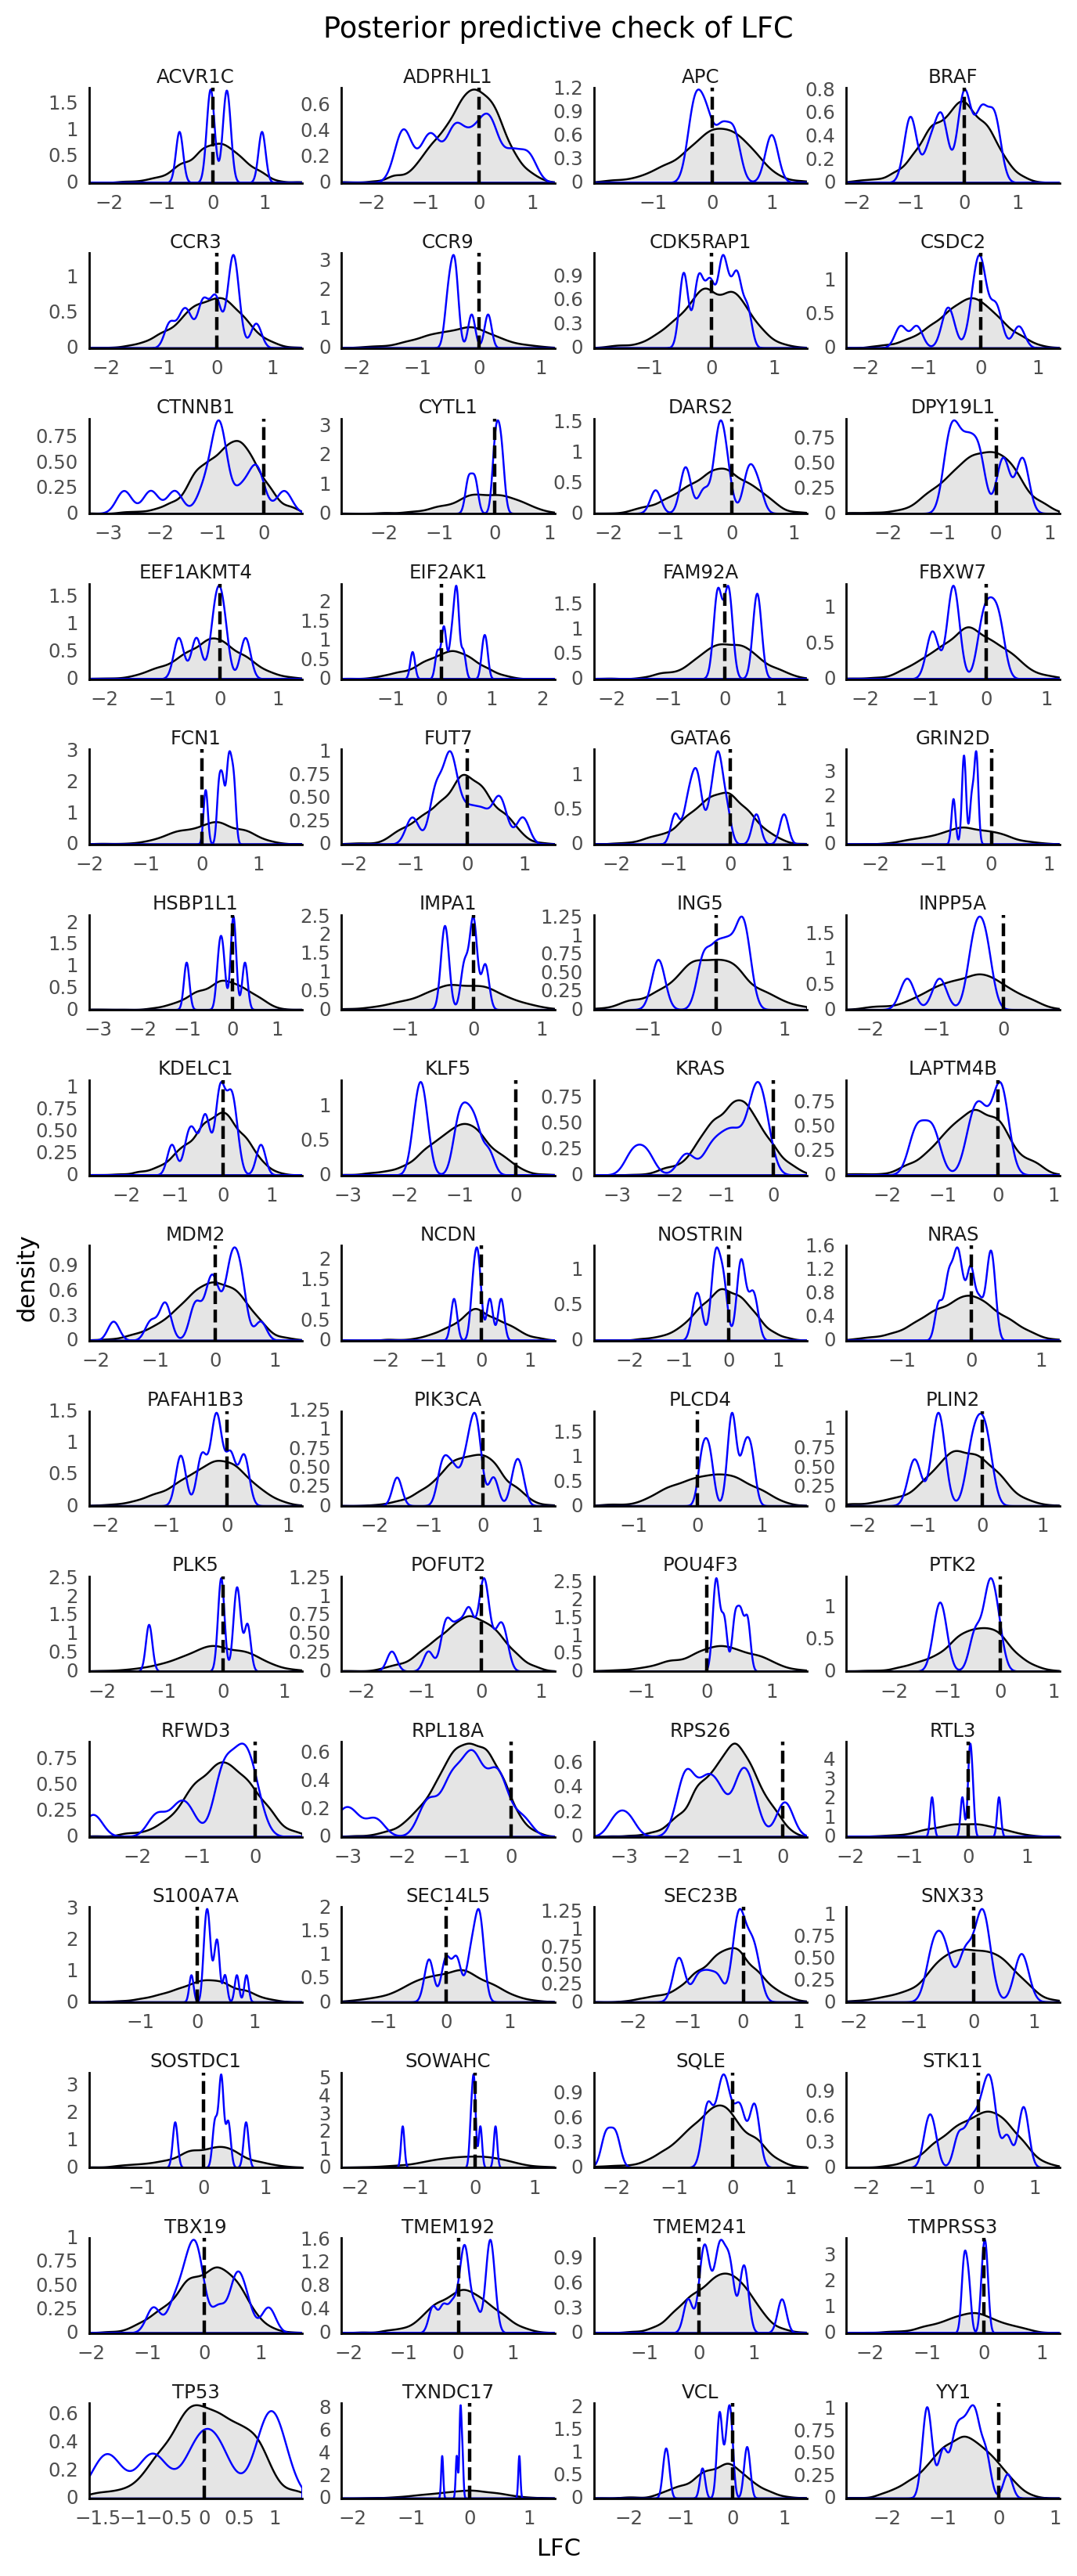

<ggplot: (355150165)>

In [32]:
ppc_lfc = (
    m1_trace["posterior_predictive"]["y"].squeeze()
    / data.initial_reads.values.reshape(1, -1)
).values
ppc_lfc = np.log2(ppc_lfc)

ppc_lfc_df = (
    pd.concat([pd.DataFrame(ppc_lfc[:100, :].T), data[["hugo_symbol", "lfc"]]], axis=1)
    .pivot_longer(index=["hugo_symbol", "lfc"], values_to="ppc_lfc")
    .drop(columns=["variable"])
)

(
    gg.ggplot(ppc_lfc_df)
    + gg.facet_wrap("~hugo_symbol", ncol=4, scales="free")
    + gg.geom_density(gg.aes(x="ppc_lfc"), color="k", fill="k", alpha=0.1)
    + gg.geom_density(gg.aes(x="lfc"), color="b")
    + gg.geom_vline(xintercept=0, linetype="--", color="k", size=0.9)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(figure_size=(8, 20), panel_spacing_x=0.25, panel_spacing_y=0.25)
    + gg.labs(x="LFC", y="density", title="Posterior predictive check of LFC")
)

## Model 2

The second model includes the initial number of reads as a parameter in the linear portion of the model instead of as an exposure.
This perhaps will make the value of $\beta$ make more sense.

$$
\begin{gather}
\mu_\beta \sim N(0, 5) \\
\sigma_\beta \sim HN(5) \\
\beta_g \sim_g N(\mu_\beta, \sigma_\beta) \\
\eta = \beta_g[\text{gene}] X_\text{initial} \\
\mu = \exp(\eta) \\
\alpha = HN(5) \\
y \sim \text{NB}(\mu, \alpha)
\end{gather}
$$

In [67]:
def noncentered_normal(name, shape, μ=None):
    if μ is None:
        μ = pm.Normal(f"μ_{name}", 0.0, 2.5)

    Δ = pm.Normal(f"Δ_{name}", 0.0, 1.0, shape=shape)
    σ = pm.HalfNormal(f"σ_{name}", 2.5)

    return pm.Deterministic(name, μ + Δ * σ)


with pm.Model() as nb_m2:
    g = pm.Data("gene_idx", gene_idx)
    log_initial_reads = pm.Data("log_initial_reads", np.log(data.initial_reads.values))
    final_reads = pm.Data("final_reads", data.read_counts.values)

    μ_β = pm.Normal("μ_β", 0, 2.5)
    σ_β = pm.HalfNormal("σ_β", 2.5)
    β = pm.Normal("β", μ_β, σ_β, shape=n_genes)

    η = pm.Deterministic("η", β[g] * log_initial_reads)

    μ = pm.Deterministic("μ", pm.math.exp(η))
    α = pm.HalfNormal("α", 5.0)

    y = pm.NegativeBinomial("y", μ, α, observed=final_reads)

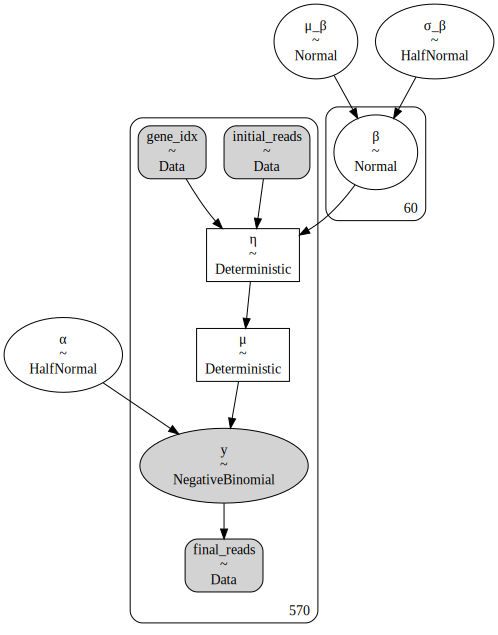

In [50]:
pm.model_to_graphviz(nb_m2)

In [51]:
with nb_m2:
    m2_trace = pm.sample(1000, tune=2000, return_inferencedata=True)
    m2_trace.extend(
        az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(m2_trace))
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β, σ_β, μ_β]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 32 seconds.


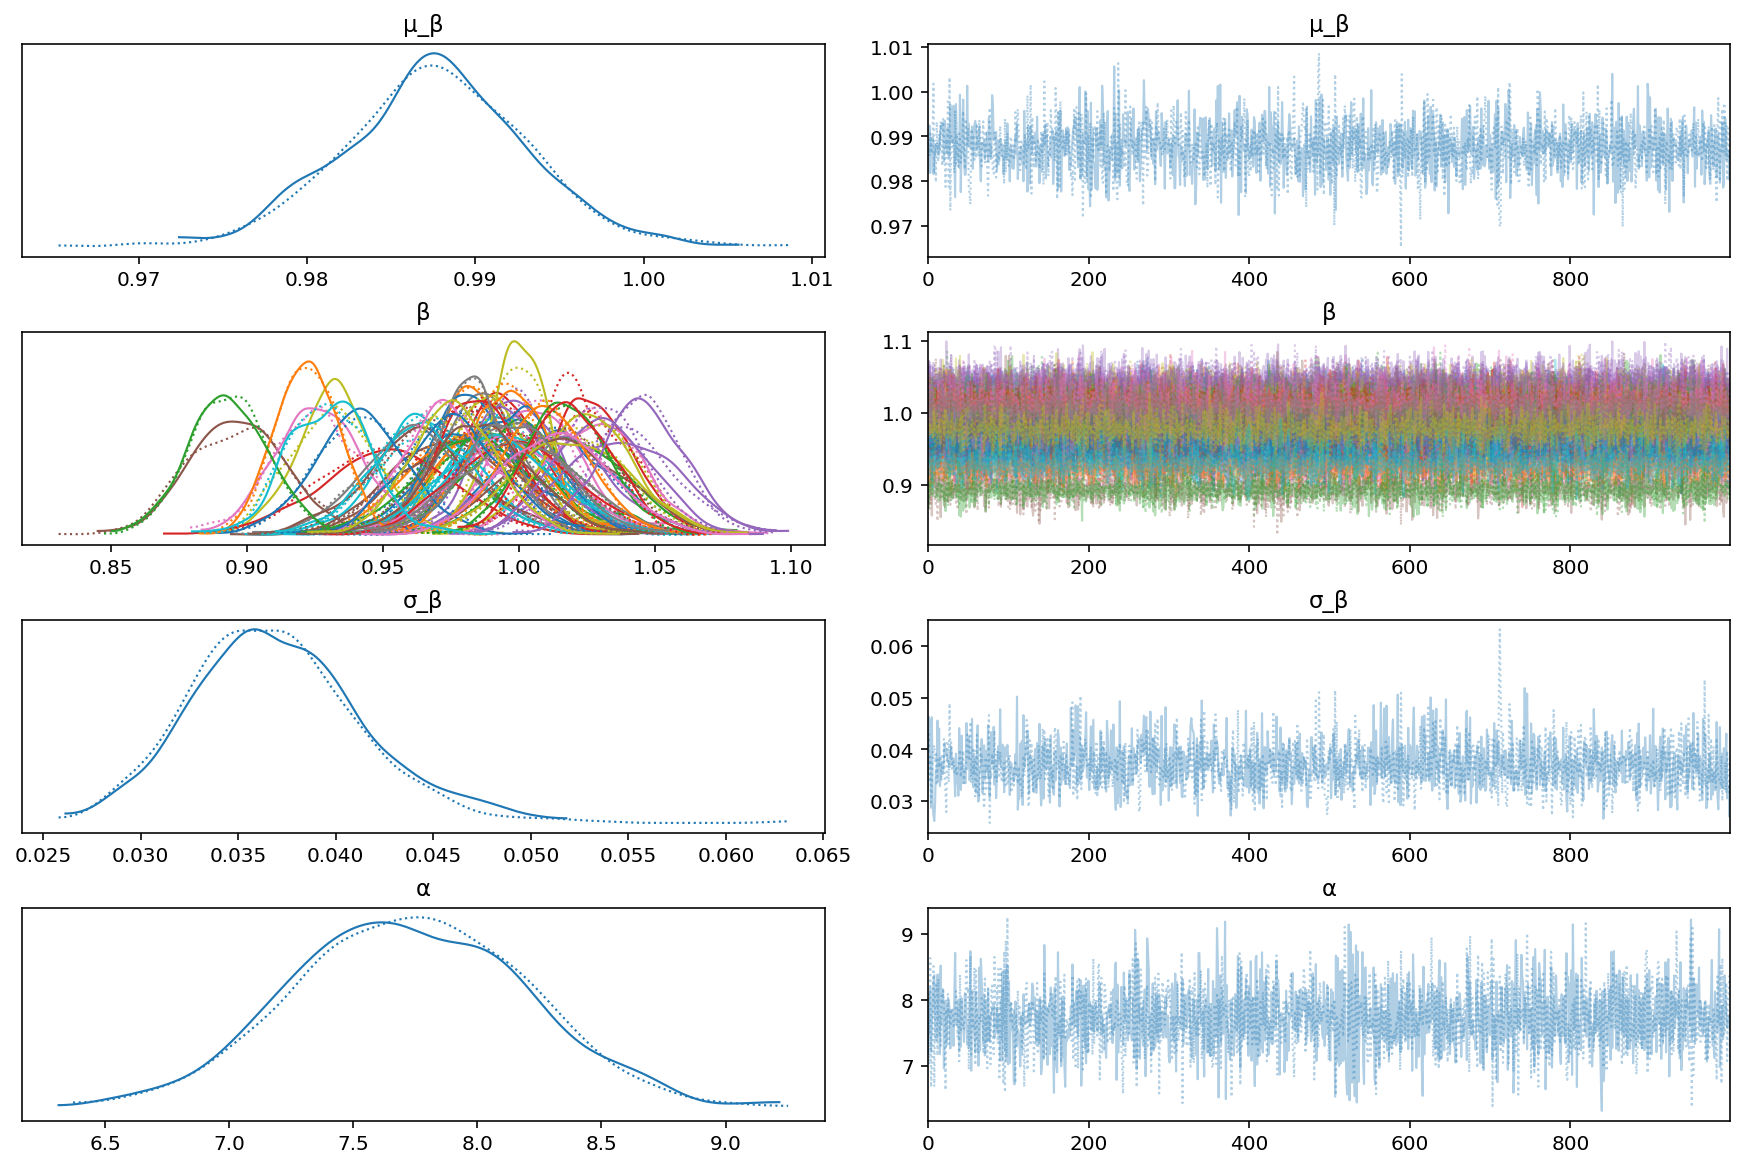

In [52]:
az.plot_trace(m2_trace, var_names=["α", "β"], filter_vars="like");

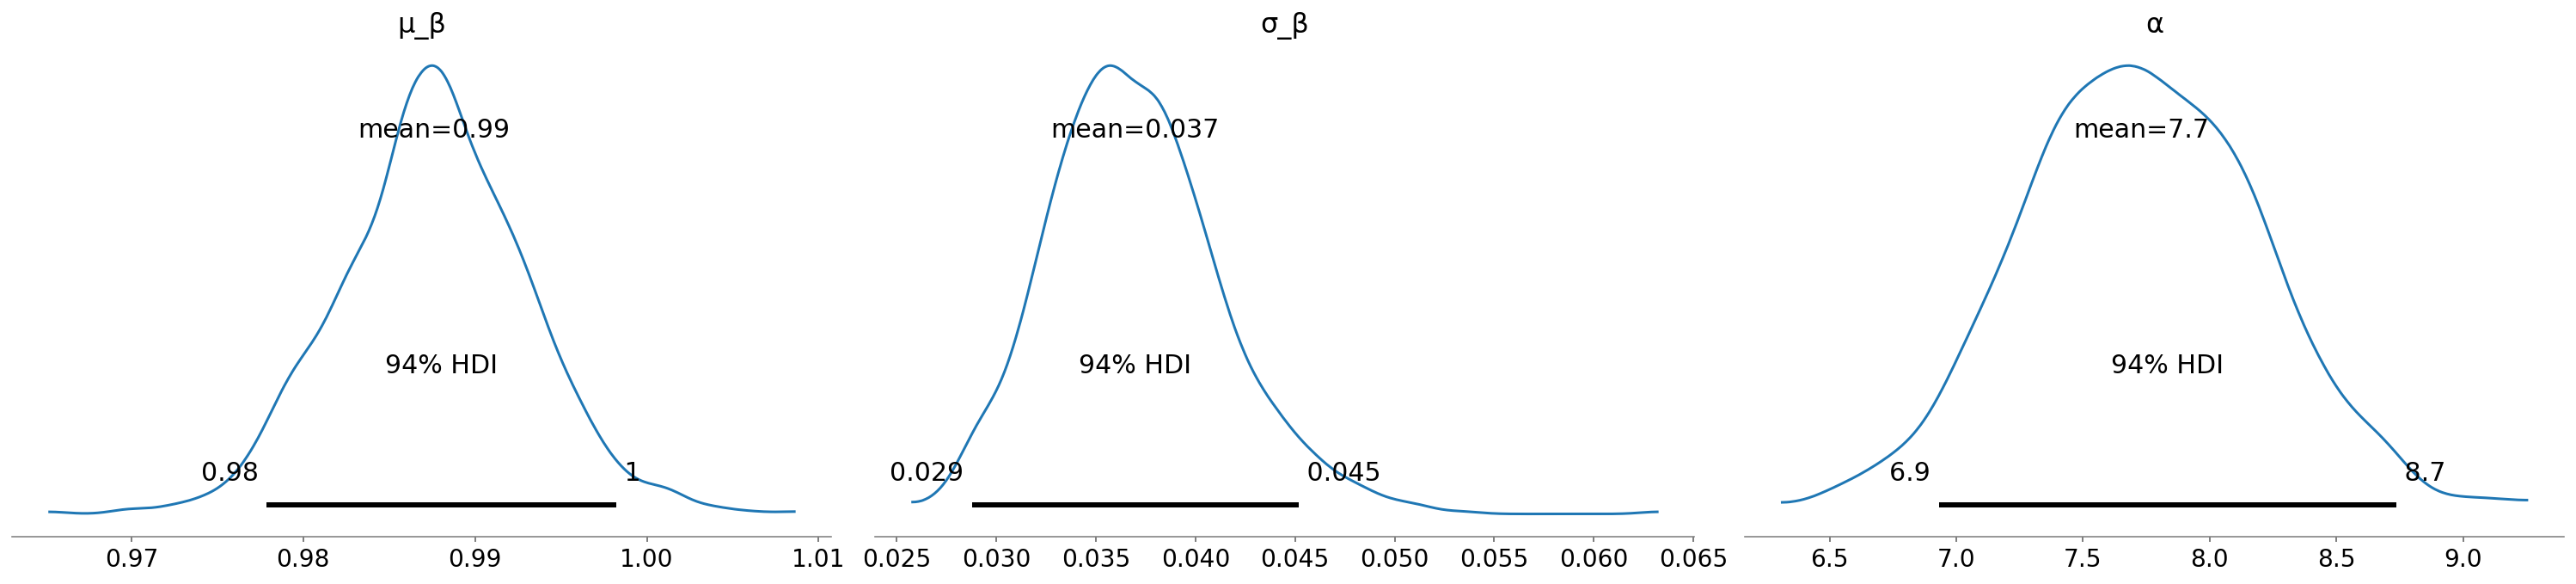

In [68]:
az.plot_posterior(m2_trace, var_names=["μ_β", "σ_β", "α"]);

The posterior estimates for $\beta$ are just shifted by 1 now.
Here is the interpretation for $\beta_g$: for gene $j$, a unit change in initial read counts reduces the expected number of log final read counts by $\beta_j$.
These values are not as clear as when modeling the inital read count as the exposure because there, a $\beta_j = 0$ means that the gene is 

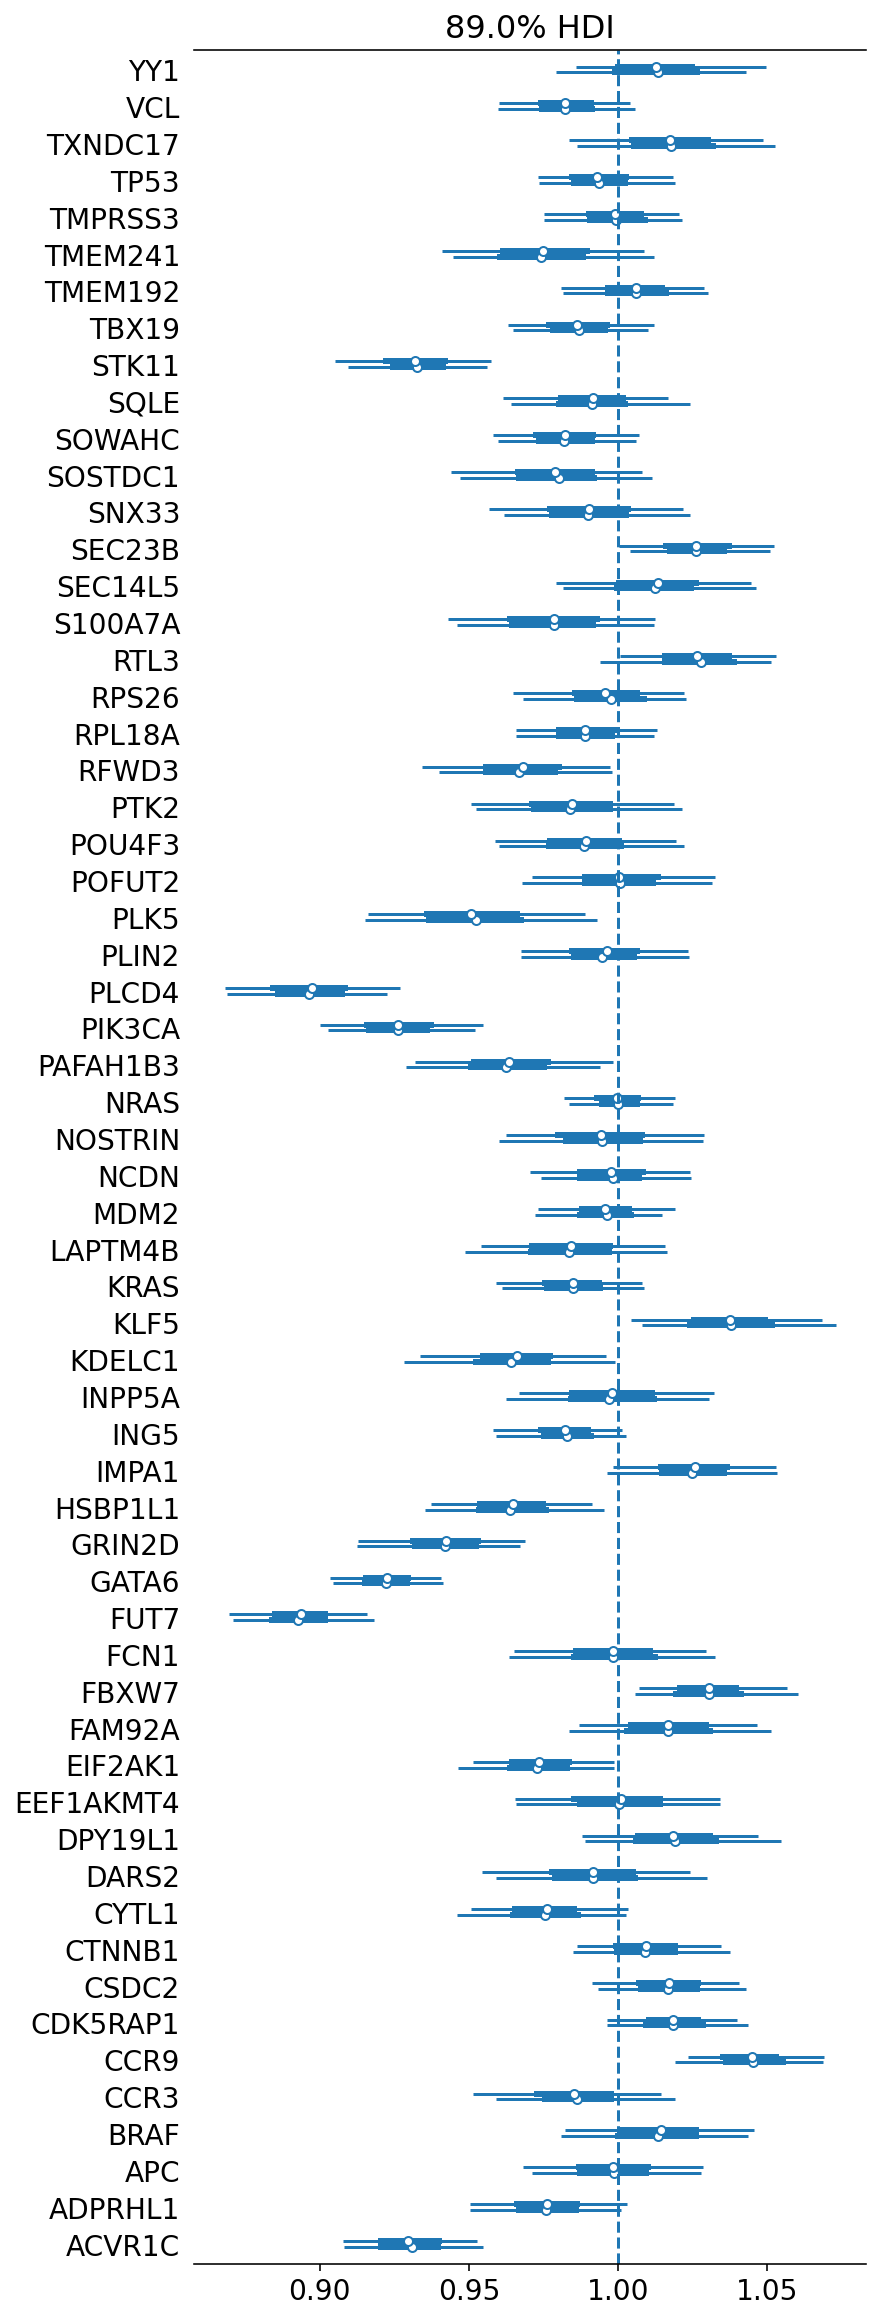

In [69]:
ax = az.plot_forest(m2_trace, var_names="β", hdi_prob=0.89)
ax[0].set_yticklabels(data.hugo_symbol.cat.categories)
plt.axvline(x=1, ls="--")
plt.show()

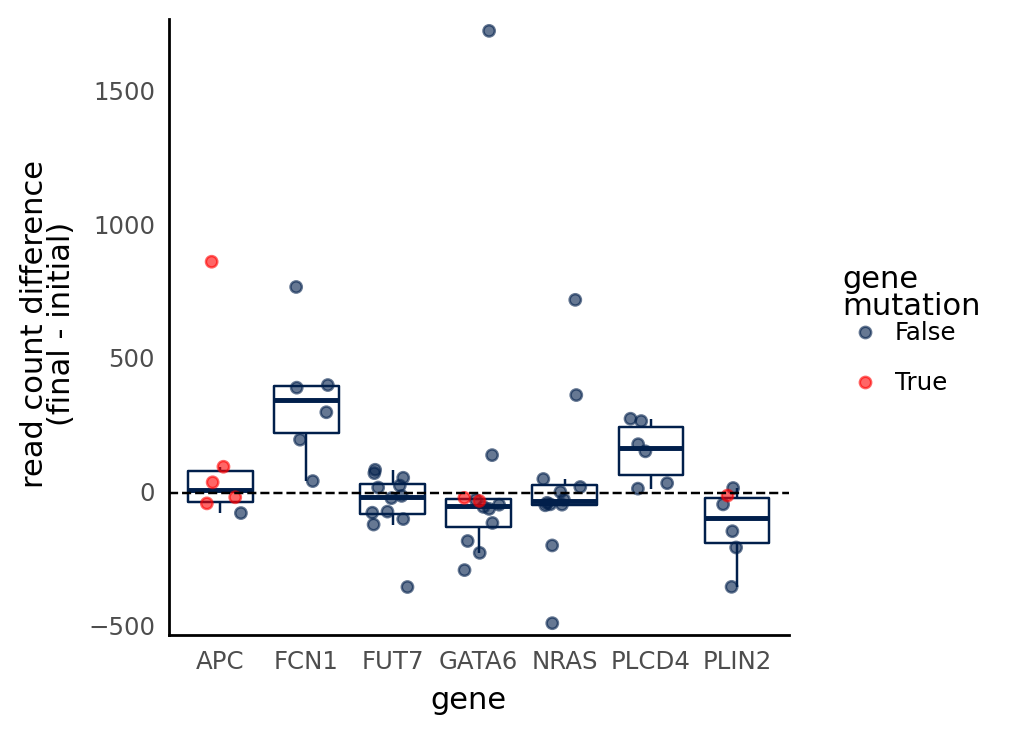

<ggplot: (363141286)>

In [38]:
g = ["APC", "FCN1", "NRAS", "PLIN2", "FUT7", "GATA6", "PLCD4"]

(
    gg.ggplot(
        data[data.hugo_symbol.isin(g)]
        .astype({"hugo_symbol": str})
        .assign(count_diff=lambda d: d.read_counts - d.initial_reads)
        .sort_values("is_mutated"),
        gg.aes(x="hugo_symbol", y="count_diff"),
    )
    + gg.geom_boxplot(outlier_alpha=0, color="#011F4B")
    + gg.geom_jitter(
        gg.aes(color="is_mutated"), width=0.25, height=0, alpha=0.6, size=1.8
    )
    + gg.geom_hline(yintercept=0, linetype="--")
    + gg.scale_y_continuous(expand=(0.02, 0, 0.02, 0))
    + gg.scale_color_manual(values={True: "red", False: "#011F4B"})
    + gg.labs(
        x="gene", y="read count difference\n(final - initial)", color="gene\nmutation"
    )
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


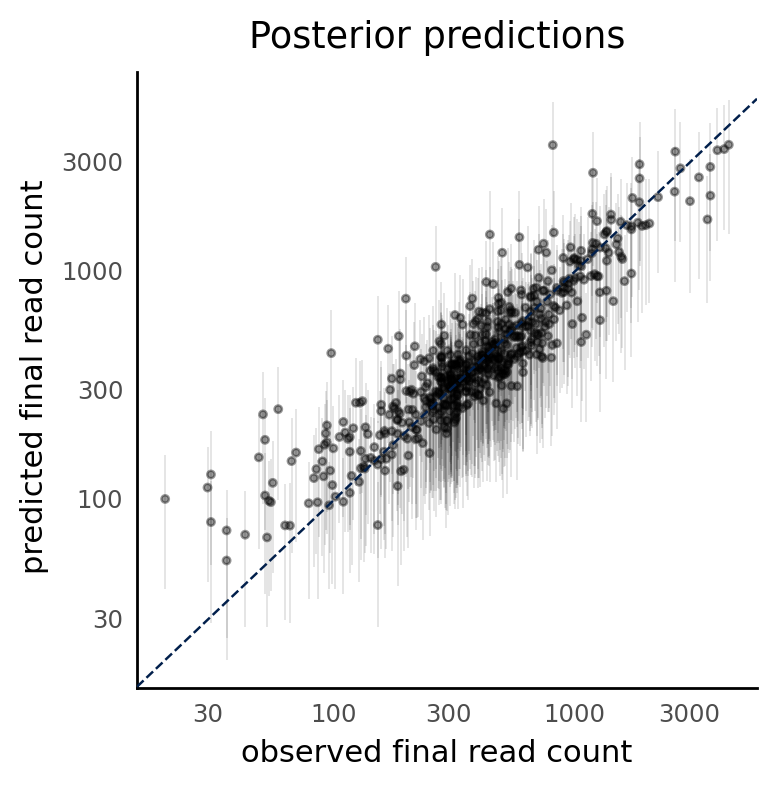

<ggplot: (363295702)>

In [39]:
m2_ppc = pmanal.summarize_posterior_predictions(
    m2_trace["posterior_predictive"]["y"].squeeze().values,
    merge_with=data,
    calc_error=True,
    observed_y="read_counts",
)

(
    gg.ggplot(m2_ppc, gg.aes(x="read_counts", y="pred_mean"))
    + gg.geom_linerange(
        gg.aes(ymin="pred_hdi_low", ymax="pred_hdi_high"),
        alpha=0.1,
        size=0.4,
    )
    + gg.geom_point(alpha=0.4, size=1)
    + gg.geom_abline(slope=1, intercept=0, linetype="--", color="#011F4B")
    + gg.scale_x_log10()
    + gg.scale_y_log10()
    + gg.labs(
        x="observed final read count",
        y="predicted final read count",
        title="Posterior predictions",
    )
)

## Model 3. Experimenting with copy number effect

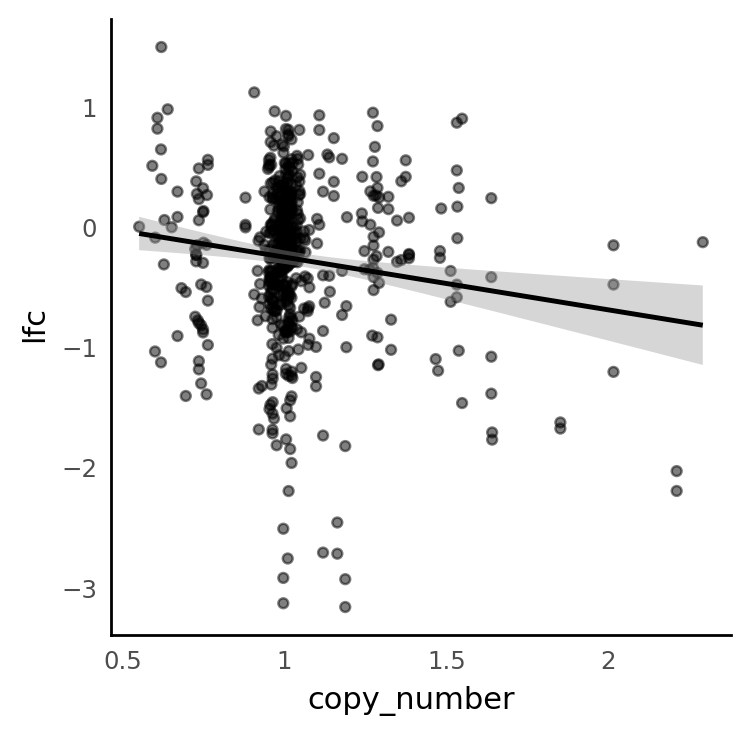

<ggplot: (286594813)>

In [40]:
(
    gg.ggplot(data, gg.aes(x="copy_number", y="lfc"))
    + gg.geom_point(alpha=0.5)
    + gg.geom_smooth(method="lm", formula="y~x")
)

---

In [41]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.45 minutes


In [42]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-09-09

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: nb-model

arviz     : 0.11.2
matplotlib: 3.4.3
re        : 2.2.1
pandas    : 1.3.2
numpy     : 1.21.2
pymc3     : 3.11.2
plotnine  : 0.8.0
theano    : 1.0.5
seaborn   : 0.11.2
janitor   : 0.21.0

